In [1]:
import sys 
import os
sys.path.append(os.path.abspath('..'))
import numpy as np
import time
import pygame
from pygame.locals import *
import matplotlib.pyplot as plt
from Common_functions import file_io, pygame_visuals as pv
from collections import deque
import random

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class board:
    
    def __init__(self):    
        #Game specific Variables
        self.turn = 1
        self.moves_left = 9
        self.state = np.array([0 for _ in range(9)])
        
    def update(self, action):
        
        if self.state[action] != 0:
            return 'invalid move'
        
        self.state[action] = self.turn
        self.turn = (self.turn == 1)*(-1)+(self.turn == -1)*(1)
        self.moves_left -= 1
        
        if self.moves_left < 5:
            win_cond = -3*self.turn
                        
            # row check
            temp = action//3 * 3
            if self.state[temp] + self.state[temp+1] + self.state[temp+2] == win_cond:
                return f"{-1*self.turn} won"
            
            # col check
            if self.state[action] + self.state[(action+3)%9] + self.state[(action+6)%9] == win_cond:
                return f"{-1*self.turn} won"
            
            #diag check
            if action%2 == 0:
                if self.state[0] + self.state[4] + self.state[8] == win_cond or self.state[2] + self.state[4] + self.state[6] == win_cond:
                    return f"{-1*self.turn} won"
                            
            if self.moves_left == 0:
                return 'tie'
        
        return 'valid move'

    def reset(self):
        self.turn = 1
        self.moves_left = 9
        self.state = np.array([0 for _ in range(9)])

class game:
    
    def __init__(self):
        #RL Variables
        self.terminal = False
        self.reward = 0
        self.score = 0
        
        #Tic Tac Toe Board
        self.gameboard = board()
        
    def update(self, action):                    
        result = self.gameboard.update(action)
        
        if result == 'invalid move':
            self.reward = -1
            self.terminal = True
            
        elif result == 'valid move':
            self.reward = 0
            self.terminal = False
            
        elif result == '1 won':
            self.reward = 1 * -1 * self.gameboard.turn
            self.terminal = True
            
        elif result == '-1 won':
            self.reward = -1 * -1 * self.gameboard.turn
            self.terminal = True
        
        elif result == 'tie':
            self.reward = 0
            self.terminal = True
        
        self.score += self.reward
        
    def reset(self):
        self.gameboard.reset()
        
        self.terminal = False
        self.reward = 0
        self.score = 0
    
    def return_state_features(self):
        return self.gameboard.state.reshape(9,1)*self.gameboard.turn
    
class illustrator:
    
    def __init__(self, host_game):
        
        self.host = host_game
    
    def draw(self):
        def convert(n):
            return "X"*(n==1) + " "*(n==0) + "O"*(n==-1)
        temp = [[convert(int(self.host.gameboard.state[3*j+i])) for i in range(3)] for j in range(3)]
        
        print(f"{temp[0][0]}|{temp[0][1]}|{temp[0][2]}\n")
        print("-----")
        print(f"{temp[1][0]}|{temp[1][1]}|{temp[1][2]}\n")
        print("-----")
        print(f"{temp[2][0]}|{temp[2][1]}|{temp[2][2]}\n\n")

def draw(st):
    def convert(n):
        return "X"*(n==1) + " "*(n==0) + "O"*(n==-1)
    temp = [[convert(int(st[3*j+i])) for i in range(3)] for j in range(3)]
        
    print(f"{temp[0][0]}|{temp[0][1]}|{temp[0][2]}\n")
    print("-----")
    print(f"{temp[1][0]}|{temp[1][1]}|{temp[1][2]}\n")
    print("-----")
    print(f"{temp[2][0]}|{temp[2][1]}|{temp[2][2]}\n\n")

In [3]:
class sigmoid:
    def use(z):
        return 0.5 * (1 + np.tanh(0.5 * z))

    def prime(z):
        return sigmoid.use(z)*(1-sigmoid.use(z)) 

class tanh:
    def use(z):
        return np.tanh(z)

    def prime(z):
        return 1-np.tanh(z)**2

class network:
    
    def __init__(self, layers, afunc = sigmoid, rho = 0, lamda = 0):
        # Gradient descent variables
        self.bias = [np.random.randn(x, 1) for x in layers[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(layers[:-1], layers[1:])]
        self.b_vel = [np.zeros((x,1)) for x in layers[1:]]
        self.w_vel = [np.zeros((y, x)) for x, y in zip(layers[:-1], layers[1:])]
        self.rho = rho
        self.lamda = lamda
        
        self.size = len(layers)
        self.afunc = afunc
        
    def feedforward(self, a):
        for w, b in zip(self.weights, self.bias):
            a = self.afunc.use(np.matmul(w, a) + b)
        return a 
    
    def SGD(self, train, eta, mini_batch_size, epochs, monitor=None):
        # Train is a tuple containing two matricies of size (x,n) where 
        # x is the number of input neurons and n is the number of samples
        # To avoid shuffling the original data pass in a copy of the data
        
        # Define all the things we need
        
        train_x, train_y = train
        
        acc, cost = [], []
        
        num_train = train_y.shape[1]
        if monitor:
            num_test = monitor[0].shape[1]
            
        weight_update = []
        
        # Train the network
        for e in range(epochs):
            
            # Shuffle the data in unison
            rng_state = np.random.get_state()
            np.random.shuffle(train_x.transpose())
            np.random.set_state(rng_state)
            np.random.shuffle(train_y.transpose())
            
            #Track weights:
            wu = 0
            # Go through each mini batch 
            for i in range(0, num_train, mini_batch_size):
                wu += self.update_mini_batch(eta, train_x[:, i:i+mini_batch_size], train_y[:, i:i+mini_batch_size], mini_batch_size)
            
            weight_update.append(wu)
            
            # Monitor progress, if monitor contains something then evaluate on it
            if monitor:
                a, c = self.evaluate(monitor, num_test)
                acc.append(a)
                cost.append(c)
                print("Epoch {} done! Cost: {}. Accuracy {} / {}".format(e+1, c, a, num_test))
            else:
                print("Epoch {} done!".format(e+1))
        
        return acc, cost, weight_update  
    
    def evaluate(self, data, num_test):
        # Get the inputs and outputs
        test_x, test_y = data
        
        # Predict
        pred = self.feedforward(test_x)
        
        # Find accuracy
        acc = np.sum(test_y.T.nonzero()[1]==pred.argmax(axis=0))
        
        # Use C = 1/N *( sum_x 0.5 * ||a^L-y||^2 + 0.5*sum||w|| )
        cost= 1/num_test*(0.5*np.linalg.norm(pred - test_y)**2 + 0.5*self.lamda*sum(np.linalg.norm(w)**2 for w in self.weights))
        
        return acc, cost        
        
    def update_mini_batch(self, eta, x, y, mini_batch_size):
        gradient_bias, gradient_weights = self.backprop(x,y)
        
        # v = pv + (1-p)gradientC
        self.b_vel = [self.rho*vb + grad_b for vb, grad_b in zip(self.b_vel, gradient_bias)]
        self.w_vel = [self.rho*vw + (grad_w+self.lamda*w) for vw, grad_w, w in zip(self.w_vel, gradient_weights, self.weights)] 
        
        # x = x - eta/batch size *v
        self.bias = [b - (eta/mini_batch_size)*vb for b, vb in zip(self.bias, self.b_vel)]
        self.weights = [w - (eta/mini_batch_size)*vw for w, vw in zip(self.weights, self.w_vel)] 
        
        return sum(np.linalg.norm(w)**2 for w in gradient_weights) 
    
    def backprop(self, x, y):
        
        gradient_bias, gradient_weights = [], []
        
        act = x
        activations = [act]
        z_values = []
    
        for w, b in zip(self.weights, self.bias):
            z = np.matmul(w, act) + b
            z_values.append(z)
            
            act = self.afunc.use(z)
            activations.append(act)
            
        delta = (activations[-1]-y)*self.afunc.prime(z_values[-1])
        #gradient_bias.append(delta)
        gradient_bias.append(np.sum(delta, axis = 1).reshape(delta.shape[0], 1))
        gradient_weights.append(np.matmul(delta, activations[-2].transpose()))  
 
        for i in range(2, self.size):
            delta = np.matmul(self.weights[-i+1].transpose(), delta) * self.afunc.prime(z_values[-i])
            #gradient_bias.insert(0, delta)
            gradient_bias.insert(0, np.sum(delta, axis = 1).reshape(delta.shape[0], 1))
            gradient_weights.insert(0, np.matmul(delta, activations[-i-1].transpose()))
    
        return gradient_bias, gradient_weights
    
    def make_copy_for_predicition(self):
        net = network([1,2], self.afunc, self.rho, self.lamda)
        net.size = self.size
        
        net.bias = [el.copy() for el in self.bias]
        net.weights = [el.copy() for el in self.weights]
        
        return net
    

In [4]:
import sys
import json 

def save(agent, filename = 'agent'):
    
    data = {"net size": agent.net.size,
            "net weights": [w.tolist() for w in agent.net.weights],
            "net bias": [b.tolist() for b in agent.net.bias],
            "net w_vel": [w.tolist() for w in agent.net.w_vel],
            "net b_vel": [b.tolist() for b in agent.net.b_vel],
            "net rho": agent.net.rho,
            "net lamda": agent.net.lamda,
            "gamma": agent.gamma,
            "alpha": agent.alpha,
            "epsilon": agent.epsilon,
            "min_epsilon": agent.min_epsilon}
    
    f = open(filename, "w")
    json.dump(data, f)
    f.close()

def load(filename = 'agent'):
    """Load a neural network from the file ``filename``.  Returns an instance of func_sarsa."""
    
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    
    agent = func_sarsa(data['gamma'], data['alpha'], data['epsilon'], data['min_epsilon'], 
                       (1,1), data['net rho'], data['net lamda'])
    
    afunc = tanh
    agent.net.afunc = afunc
    agent.net.size = data['net size']
    
    agent.net.weights = [np.array(w) for w in data["net weights"]]
    agent.net.bias = [np.array(b) for b in data["net bias"]]
    agent.net.w_vel = [np.array(w) for w in data["net w_vel"]]
    agent.net.b_vel = [np.array(b) for b in data["net b_vel"]]
    agent.target_net = agent.net.make_copy_for_predicition()
    
    return agent

In [5]:
class func_sarsa():
    """
    Uses Deep Q Learning to update parameters. 
    States are represented as vectors, actions are represented with natural numbers.
    
    Game Loop should look like:
    Get first action (baction, bstate)
    Repeat until terminal state
      take the action   (reward)
      update env (nstate)
      get action    (naction)
      update agent (bstate, baction <-- nstate, naction)
      
    """
    
    def __init__(self, gamma, alpha, epsilon, min_epsilon, network_layers, rho, lamda, memory_size=1000):
        """
        Initalizes agent. 
        
        Params: 
        gamma:       disount factor. How much it cares about the future. [0,1]
        alpha:       step size rate. How much it updates current prediction towards new one. [0,1]
        epsilon:     exploration rate. How often it makes random moves. [0,1]
        min_epsilon: lower bound on epsilon. [0,1]
        lamda:       weight of n-step return. [0,1]
        ...
        """
        #Learning parameters
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        
        #Field variables
        self.net = network(network_layers, afunc=tanh, rho=rho, lamda = lamda)
        self.target_net = self.net.make_copy_for_predicition()
        self.not_min_epsilon = True
        
        self.memory_size = memory_size
        self.experience = deque()
        
    def q_values(self, state_features):
        return self.net.feedforward(state_features)
        
    def choose_action(self, state_features):
        
        
        indicator = np.nonzero(state_features == 0)[0]
        
        if self.not_min_epsilon: 
            self.epsilon *= 0.99999
            if self.epsilon <= self.min_epsilon:
                self.not_min_epsilon = False
        
        if np.random.rand() < self.epsilon: 
            np.random.shuffle(indicator)
            action = int(indicator[0])
            return action
        else:            
            values = self.net.feedforward(state_features)
            # Get vals in values that are allowed. Find index where it resides. Turn into int
            return int(np.where(values == values[indicator].max())[0])
        
    def add_normal(self, bfeature, baction, reward, state_features, action):
        
        target = self.q_values(bfeature)
        target[baction] = reward + self.gamma * self.target_net.feedforward(state_features).max()
    
        self.add_experience(bfeature.reshape(9), target.reshape(9))

                
    def add_final(self, bfeature, baction, reward):
        
        target = self.q_values(bfeature)
        target[baction] = reward
        
        self.add_experience(bfeature.reshape(9), target.reshape(9))
        
    def add_experience(self, pred, target):
         
        if len(self.experience) < self.memory_size:
            self.experience.append([pred, target])
        else:
            self.experience.popleft()
            self.experience.append([pred, target])
            
    def sample(self, mb_size):
        
        sample_size = min(mb_size, len(self.experience))
        trainingset = random.sample(self.experience, sample_size)
        pred_tuple, target_tuple = zip(*trainingset)
        
        return np.array(pred_tuple).transpose(), np.array(target_tuple).transpose()
        
    def update(self, mb_size):
        
        pred, target = self.sample(mb_size)
        w_update = self.net.update_mini_batch(self.alpha, pred, target, mb_size)
        
        return w_update
    
    def unfreeze_target_net(self):
        self.target_net = self.net.make_copy_for_predicition()
        

Epsiodes done:  1000
Epsiodes done:  2000
Epsiodes done:  3000
Epsiodes done:  4000
Epsiodes done:  5000
Epsiodes done:  6000
Epsiodes done:  7000
Epsiodes done:  8000
Epsiodes done:  9000
Epsiodes done:  10000
Epsiodes done:  1000
Epsiodes done:  2000
Epsiodes done:  3000
Epsiodes done:  4000
Epsiodes done:  5000
Epsiodes done:  6000
Epsiodes done:  7000
Epsiodes done:  8000
Epsiodes done:  9000
Epsiodes done:  10000
20.138041341887263
28.071245209007476


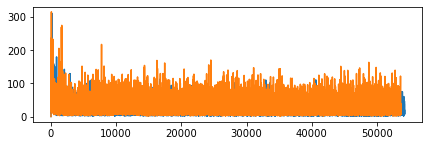

In [6]:
test = [0.09,0.009]
n_test = len(test)

env = game()
info_package = [[] for _ in range(n_test)]

for j in range(n_test):
    agent = func_sarsa(gamma=0.95, alpha = test[j], epsilon = 0.999, 
                   min_epsilon= 0.10, network_layers = (9,18,12,9), 
                   rho=0, lamda=0.1, memory_size=100)


    num_training_episodes = 10000
    iterations_to_unfreeze = 100

    for i in range(1, num_training_episodes+1):
        if (i*10%num_training_episodes) == 0:
            print("Epsiodes done: ", i)

        if (i%iterations_to_unfreeze == 0):
            agent.unfreeze_target_net()
        #Actual Training Logic

        s1 = env.return_state_features()
        a1 = agent.choose_action(s1)    
        env.update(a1)
        r1 = env.reward

        s2 = env.return_state_features()
        a2 = agent.choose_action(s2)
        env.update(a2)
        r2 = env.reward

        remember = deque([(s1,a1,r1), (s2,a2,r2)])

        steps = 0
        while not env.terminal:

            s = env.return_state_features()
            a = agent.choose_action(s)

            env.update(a)
            r = env.reward

            info = remember.popleft() #MEMORY UPDATE => popleft()
            #print(info[0].reshape(9), info[1], info[2], s.reshape(9), a)        AGENT UPDATE  => remember[0], s, a
            agent.add_normal(info[0], info[1], info[2], s, a)
            remember.append((s,a,r)) #MEMORY UPDATE => append(s & a & r)

            info_package[j].append(agent.update(mb_size = 20))

        #AGENT UPDATE  => remember[1] (recent S,A,R), SET VALUE TO 0,
        agent.add_final(remember[1][0], remember[1][1], remember[1][2])

        #AGENT UPDATE  => remember[0] (second recent S,A,R), SET VALUE TO 0,  ****REWARD *= -1
        agent.add_final(remember[0][0], remember[0][1], remember[1][2]*-1)        
        env.reset()   

for i in range(n_test):
    print(np.array(info_package[i]).mean())
fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])

for i in range(n_test):
    axes.plot(np.arange(len(info_package[i])), info_package[i])

In [7]:
agent = load('first decent one')
agent.memory_size = 2500

In [8]:
agent = func_sarsa(gamma=0.999, alpha = 0.05, epsilon = 0.999, 
                   min_epsilon= 0.15, network_layers = (9,18,12,9), 
                   rho=0.05, lamda=0.1, memory_size=7500)

In [28]:
env = game()
info_package = []

num_training_episodes = 1500000
iterations_to_unfreeze = 10000

for i in range(1, num_training_episodes+1):
    
    if (i*100%num_training_episodes) == 0:
        print("Epsiodes done: ", i)
    
    if (i%iterations_to_unfreeze == 0):
        agent.unfreeze_target_net()
    #Actual Training Logic
    
    s1 = env.return_state_features()
    a1 = agent.choose_action(s1)    
    env.update(a1)
    r1 = env.reward
        
    s2 = env.return_state_features()
    a2 = agent.choose_action(s2)
    env.update(a2)
    r2 = env.reward
    
    remember = deque([(s1,a1,r1), (s2,a2,r2)])
        
    steps = 0
    while not env.terminal:
        
        s = env.return_state_features()
        a = agent.choose_action(s)
        
        env.update(a)
        r = env.reward
        
        info = remember.popleft() #MEMORY UPDATE => popleft()
        #print(info[0].reshape(9), info[1], info[2], s.reshape(9), a)        AGENT UPDATE  => remember[0], s, a
        agent.add_normal(info[0], info[1], info[2], s, a)
        remember.append((s,a,r)) #MEMORY UPDATE => append(s & a & r)
        
        info_package.append(agent.update(mb_size = 20))
        
    #AGENT UPDATE  => remember[1] (recent S,A,R), SET VALUE TO 0,
    agent.add_final(remember[1][0], remember[1][1], remember[1][2])
    
    #AGENT UPDATE  => remember[0] (second recent S,A,R), SET VALUE TO 0,  ****REWARD *= -1
    agent.add_final(remember[0][0], remember[0][1], remember[1][2]*-1)        
    env.reset()   
    

KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: setting an array element with a sequence.

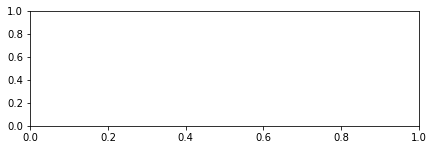

In [9]:

fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])

axes.plot(np.arange(len(info_package)), info_package)

In [10]:
t = np.array([1,1,0,-1,-1,0,0,0,0])
q = agent.q_values(t.reshape(9,1))
print(q.argmin(), q.argmax(), q.max())
q

3 0 0.685301315097356


array([[ 0.68530132],
       [-0.82650848],
       [ 0.30707531],
       [-0.95338966],
       [-0.93318252],
       [ 0.07519327],
       [-0.80655675],
       [-0.89879017],
       [ 0.51531648]])

In [11]:
env.reset()
orig_epsilon = agent.epsilon
agent.epsilon = 0

i = illustrator(env) 

steps = 0
while not env.terminal:

    s = env.return_state_features()
    a = agent.choose_action(s)

    env.update(a)
    
    print(a)    
    i.draw()

print(env.reward)
env.reset()   

agent.epsilon = orig_epsilon

0
X| | 

-----
 | | 

-----
 | | 


8
X| | 

-----
 | | 

-----
 | |O


2
X| |X

-----
 | | 

-----
 | |O


5
X| |X

-----
 | |O

-----
 | |O


6
X| |X

-----
 | |O

-----
X| |O


1
X|O|X

-----
 | |O

-----
X| |O


7
X|O|X

-----
 | |O

-----
X|X|O


4
X|O|X

-----
 |O|O

-----
X|X|O


3
X|O|X

-----
X|O|O

-----
X|X|O


1


In [173]:
env.return_state_features()

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [174]:
bfeature = np.array([-1,0,1,0,-1,1,0,0,0]).reshape(9,1)
action = 5
reward = -1

print(agent.q_values(bfeature)[action])

target = agent.q_values(bfeature)
target[action] = reward
        
train = [bfeature, target]
agent.net.SGD(train, 0.0009, 1, 1)

print(agent.q_values(bfeature)[action])
print(agent.q_values(bfeature))


[-0.79633079]
Epoch 1 done!
[-0.79636816]
[[-0.75387723]
 [-0.80141781]
 [-0.7501967 ]
 [-0.81319089]
 [ 0.29332599]
 [-0.79636816]
 [-0.94683971]
 [-0.8069871 ]
 [-0.9817044 ]]


In [181]:
env.reset()
orig_epsilon = agent.epsilon
agent.epsilon = 0

i = illustrator(env) 

steps = 0
while not env.terminal:

    s = env.return_state_features()
    a = agent.choose_action(s)

    env.update(a)
    
    print(a)    
    i.draw()
    
    if not env.terminal:
        a = int(input("where do you want to go?"))
        env.update(a)
        i.draw()
    
print(env.reward)
env.reset()   

agent.epsilon = orig_epsilon

2
 | |X

-----
 | | 

-----
 | | 


where do you want to go?4
 | |X

-----
 |O| 

-----
 | | 


0
X| |X

-----
 |O| 

-----
 | | 


where do you want to go?1
X|O|X

-----
 |O| 

-----
 | | 


5
X|O|X

-----
 |O|X

-----
 | | 


where do you want to go?7
X|O|X

-----
 |O|X

-----
 |O| 


1
